# build_outcome_penalizable
alternative to build_outcome.ipynb that includes information on diagnese in the return visits

### setup

In [1]:
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;


### load admissions data

In [2]:
query = query_schema + 'select * from admissions'
df = pd.read_sql_query(query,con)
adat = pd.read_sql_query(query,con)

## designate readmissions

#### check number of return visits

7537 total returning patients


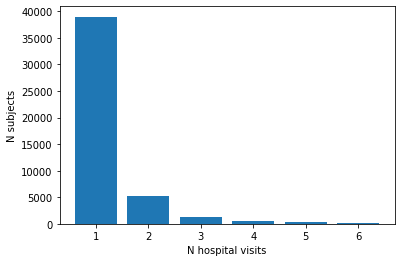

In [3]:
#id returners
RETURN_CUT = 30
adat.columns
visit_count = adat['subject_id'].value_counts()
returning_subjects = visit_count[visit_count > 1].index
print('{} total returning patients'.format(len(returning_subjects)))

#plot
visit_count_count = visit_count.value_counts()
plt.bar(visit_count_count.index[0:6], visit_count_count[0:6])
plt.ylabel('N subjects')
plt.xlabel('N hospital visits');


#### call early readmissions

In [4]:
#subset for readmissions in general
RETURN_CUT = 30
rdat = adat.loc[adat['subject_id'].isin(returning_subjects), ['subject_id', 'hadm_id', 'admittime']].sort_values(['subject_id', 'admittime'])

vlist = []
for sid in list(rdat['subject_id'].unique()):
    sub = rdat.loc[rdat['subject_id']==sid,:].sort_values('admittime')
    v1 = sub.loc[sub.index[0:(sub.shape[0]-1)],:]
    v2 = sub.loc[sub.index[1:], ['hadm_id', 'admittime']]
    v2.columns = ['return_hadm_id', 'return_admittime']
    v1.index = range(len(v1))
    v2.index = range(len(v2))
    vdat = pd.concat([v1,v2], axis=1)
    vdat['interval'] = vdat['return_admittime'] - vdat['admittime']
    vdat['early'] = vdat['interval'] <= pd.Timedelta(days=RETURN_CUT)
    vlist.append(vdat)
read_dat = pd.concat(vlist, axis=0)

#### stats on early readmissions

total readmissions in >= 30 days = 2480
2480


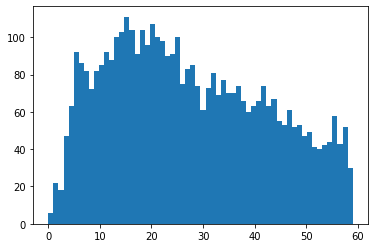

,subject_id,hadm_id,admittime,return_hadm_id,return_admittime,interval,early
0,17,194023,2134-12-27 07:15:00,161087,2135-05-09 14:11:00,133 days 06:56:00,False
0,21,109451,2134-09-11 12:17:00,111970,2135-01-30 20:50:00,141 days 08:33:00,False
0,23,152223,2153-09-03 07:15:00,124321,2157-10-18 19:34:00,1506 days 12:19:00,False
0,34,115799,2186-07-18 16:46:00,144319,2191-02-23 05:23:00,1680 days 12:37:00,False
0,36,182104,2131-04-30 07:15:00,122659,2131-05-12 19:49:00,12 days 12:34:00,True


In [5]:
#total early readmissions
read_hadm_ids = read_dat.loc[read_dat['early'], 'hadm_id']
print('total readmissions in >= {} days = {}'.format(RETURN_CUT, np.sum(read_dat['early'])))
print(len(read_hadm_ids.unique()))

#hist
xmax = 60
x=round(read_dat['interval'] / datetime.timedelta(days=1), 0).astype('int')
x=x[x<xmax]
plt.hist(x, bins=xmax)
plt.show()

#show data
all_early_hadmids = read_dat['hadm_id'].loc[read_dat['early']]
read_dat.head()

## designate penalizable return diagnoses
Under HRRP, hospitals are financially penalized if they have higher than expected risk-standardized 30-day readmission rates for acute myocardial infarction, heart failure, and pneumonia (Mcllvennan et al. 2019; doi:10.1161/CIRCULATIONAHA.114.010270)

#### load diagnosis data

In [6]:
query = query_schema + \
    'select * from DIAGNOSES_ICD'
df = pd.read_sql_query(query,con)
ddat = pd.read_sql_query(query,con)


query = query_schema + \
    'select * from D_ICD_DIAGNOSES'
df = pd.read_sql_query(query,con)
dd_dat = pd.read_sql_query(query,con)

In [7]:
td_dat = pd.merge(ddat, dd_dat, how='inner', on='icd9_code')
print(td_dat.shape)
td_dat.head()

(634709, 8)


,row_id_x,subject_id,hadm_id,seq_num,icd9_code,row_id_y,short_title,long_title
0,1297,109,172335,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
1,1311,109,173633,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
2,1019,109,131345,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
3,1039,109,131376,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
4,1059,109,135923,1.0,40301,4312,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."


In [8]:
# query = query_schema + \
#     'select * from DIAGNOSES_ICD'
# df = pd.read_sql_query(query,con)
# ddat = pd.read_sql_query(query,con)


query = query_schema + \
"""SELECT 
    DIAGNOSES_ICD.subject_id,
    DIAGNOSES_ICD.hadm_id,
    DIAGNOSES_ICD.icd9_code,
    D_ICD_DIAGNOSES.short_title,
    D_ICD_DIAGNOSES.long_title
    FROM DIAGNOSES_ICD, D_ICD_DIAGNOSES
    WHERE DIAGNOSES_ICD.icd9_code = D_ICD_DIAGNOSES.icd9_code;"""
ddat = pd.read_sql_query(query,con)

In [9]:
print(ddat.shape)
ddat.head()

(634709, 5)


,subject_id,hadm_id,icd9_code,short_title,long_title
0,109,172335,40301,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
1,109,172335,486,"Pneumonia, organism NOS","Pneumonia, organism unspecified"
2,109,172335,58281,Chr nephritis in oth dis,Chronic glomerulonephritis in diseases classif...
3,109,172335,5855,Chron kidney dis stage V,"Chronic kidney disease, Stage V"
4,109,172335,4254,Prim cardiomyopathy NEC,Other primary cardiomyopathies


#### designate penalizable hadm_ids:
acute myocardial infarction
heart failure
pneumonia

In [10]:
#acute myocardial infarction
ami_codes = ddat.loc[ddat['long_title'].str.contains('Acute myocardial', case=False), :]
ami_codes

#heart failure
hf_codes = ddat.loc[(ddat['long_title'].str.contains('heart failure', case=False)) &
                   ~(ddat['long_title'].str.contains('without heart failure', case=False)), :]
print('hf codes:')
print(hf_codes.shape)

#pneumonia
pn_codes = ddat.loc[ddat['long_title'].str.contains('pneumonia', case=False), :]
pn_codes

#combine
pen_dat = pd.concat([ami_codes, hf_codes, pn_codes], axis=0)
pen_dat.head()

hf codes:
(21274, 5)


,subject_id,hadm_id,icd9_code,short_title,long_title
107,123,195632,41011,"AMI anterior wall, init",Acute myocardial infarction of other anterior ...
354,73,194730,41001,"AMI anterolateral, init",Acute myocardial infarction of anterolateral w...
391,79,181542,41011,"AMI anterior wall, init",Acute myocardial infarction of other anterior ...
755,24,161859,41041,"AMI inferior wall, init",Acute myocardial infarction of other inferior ...
979,53,155385,41021,"AMI inferolateral, init",Acute myocardial infarction of inferolateral w...


In [11]:
hf_codes

,subject_id,hadm_id,icd9_code,short_title,long_title
51,115,114585,4280,CHF NOS,"Congestive heart failure, unspecified"
66,117,140784,4280,CHF NOS,"Congestive heart failure, unspecified"
147,124,138376,42833,Ac on chr diast hrt fail,Acute on chronic diastolic heart failure
150,124,138376,4280,CHF NOS,"Congestive heart failure, unspecified"
206,130,198214,4280,CHF NOS,"Congestive heart failure, unspecified"
...,...,...,...,...,...
634543,97144,109999,4280,CHF NOS,"Congestive heart failure, unspecified"
634636,97172,133092,42833,Ac on chr diast hrt fail,Acute on chronic diastolic heart failure
634640,97172,133092,4280,CHF NOS,"Congestive heart failure, unspecified"
634658,97488,152542,4280,CHF NOS,"Congestive heart failure, unspecified"


## assign outcome

In [12]:
pos_dat = read_dat.loc[(read_dat['early']) & read_dat['return_hadm_id'].isin(pen_dat['hadm_id'])]
print(pos_dat.shape)
pos_dat
adat['hrrd_penalized'] = adat['hadm_id'].isin(pos_dat['hadm_id']).astype('int')
print(np.sum(adat['hrrd_penalized']))
adat

(1099, 7)
1099


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data,hrrd_penalized
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,None,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1,0
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,None,CATHOLIC,MARRIED,WHITE,NaT,NaT,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,0
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaT,NaT,BRAIN MASS,0,1,0
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,None,PROTESTANT QUAKER,SINGLE,WHITE,NaT,NaT,INTERIOR MYOCARDIAL INFARCTION,0,1,0
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,None,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaT,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1,0
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,EMERGENCY,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Medicare,ENGL,CATHOLIC,WIDOWED,WHITE,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1,0
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaT,NaT,RENAL CANCER/SDA,0,1,0
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,CATHOLIC,MARRIED,WHITE,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0,0


### write to database

In [14]:
adat.to_csv('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/outcome_penalizable_dat.csv', index=False)

